In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
%load_ext google.cloud.bigquery
from google.cloud import bigquery

client=bigquery.Client()
project_id = "som-nero-phi-jonc101"

/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/google/cloud/bigquery/__init__.py:237: FutureWarning: %load_ext google.cloud.bigquery is deprecated. Install bigquery-magics package and use `%load_ext bigquery_magics`, instead.
  warnings.warn(


In [2]:
import json
import joblib
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, f1_score, classification_report

In [3]:
# load data
table_id_all_features_imputed_train= f"{project_id}.blood_culture_stewardship_peds_sandy_2024.final_base_features_imputed_train_peds"
table_id_all_features_imputed_val= f"{project_id}.blood_culture_stewardship_peds_sandy_2024.final_base_features_imputed_val_peds"
table_id_all_features_imputed_test= f"{project_id}.blood_culture_stewardship_peds_sandy_2024.final_base_features_imputed_test_peds"
train_imp = client.query(f"SELECT * FROM `{table_id_all_features_imputed_train}`").to_dataframe()
val_imp = client.query(f"SELECT * FROM `{table_id_all_features_imputed_val}`").to_dataframe()
test_imp = client.query(f"SELECT * FROM `{table_id_all_features_imputed_test}`").to_dataframe()


In [4]:
for i in train_imp.columns:
    print(i)

anon_id
pat_enc_csn_id_coded
order_proc_id_coded
blood_culture_order_datetime_utc
order_year
age_days
age_years
gender
race
bmi
source
positive_blood_culture
zip_clean
adi_score
adi_imputed_flag
min_wbc
max_wbc
avg_wbc
median_wbc
min_neutrophils
max_neutrophils
avg_neutrophils
median_neutrophils
min_anc
max_anc
avg_anc
median_anc
min_lymphocytes
max_lymphocytes
avg_lymphocytes
median_lymphocytes
min_alc
max_alc
avg_alc
median_alc
min_hgb
max_hgb
avg_hgb
median_hgb
min_plt
max_plt
avg_plt
median_plt
min_glucose
max_glucose
avg_glucose
median_glucose
min_lactate
max_lactate
avg_lactate
median_lactate
Leukocyte_Esterase
WBC_urine
Bacteria_urine
Nitrite_urine
has_any_line
temp_min_c
temp_avg_c
temp_max_c
temp_median_c
temp_mode_c
resp_min
resp_avg
resp_max
resp_median
resp_mode
hr_min
hr_avg
hr_max
hr_median
hr_mode
sysbp_min
sysbp_avg
sysbp_max
sysbp_median
sysbp_mode
diabp_min
diabp_avg
diabp_max
diabp_median
diabp_mode
spo2_min
spo2_avg
spo2_max
spo2_median
spo2_mode
min_cr
max_cr
avg_c

In [ ]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import sklearn

# --- define your keys (from your message) ---
label_key = "positive_blood_culture"



# vital_feature_key = [
#     "temp_min_c", "temp_avg_c", "temp_max_c", "temp_median_c", "temp_mode_c",
#     "resp_min", "resp_avg", "resp_max", "resp_median", "resp_mode",
#     "hr_min", "hr_avg", "hr_max", "hr_median", "hr_mode",
#     "sysbp_min", "sysbp_avg", "sysbp_max", "sysbp_median", "sysbp_mode",
#     "diabp_min", "diabp_avg", "diabp_max", "diabp_median", "diabp_mode",
#     "spo2_min", "spo2_avg", "spo2_max", "spo2_median", "spo2_mode"
# ]
demo_feature_key = ["gender", "age_days", "bmi", "adi_score"]

vital_feature_key = [
    "temp_max_c", 
    "resp_max", 
    "hr_max",
    "sysbp_min", 
    "diabp_min",
    "spo2_min", 
]

lab_ua_lda_feature_key = [
    "max_wbc", "max_neutrophils", "max_anc", "min_lymphocytes", "min_alc",
    "min_hgb", "min_plt", "max_glucose", "max_lactate",
    "Leukocyte_Esterase", "WBC_urine", "Bacteria_urine",
    "Nitrite_urine", "has_any_line"
]

# --- define your categorical columns (no has_any_line here) ---
cat_cols_user = [
    "Leukocyte_Esterase", "WBC_urine", "Bacteria_urine", "Nitrite_urine",
    "gender"
]

# --- define binary passthrough cols ---
binary_cols_user = ["has_any_line"]

# 1) Build final feature list (keep only columns that exist in train_imp)
selected_features = [c for c in (demo_feature_key + vital_feature_key + lab_ua_lda_feature_key)
                     if c in train_imp.columns]

# Categorical columns present
cat_cols = [c for c in cat_cols_user if c in selected_features]

# Binary passthrough columns present
binary_cols = [c for c in binary_cols_user if c in selected_features]

# Numeric = selected_features \ (categorical + binary)
num_cols = [c for c in selected_features
            if c not in cat_cols + binary_cols
            and pd.api.types.is_numeric_dtype(train_imp[c])]

# Safety: ensure no NaNs remain in model inputs
for df_name, df in [("train_imp", train_imp), ("val_imp", val_imp), ("test_imp", test_imp)]:
    missing_count = df[selected_features].isna().sum().sum()
    if missing_count > 0:
        raise ValueError(f"{df_name} still has {missing_count} missing values in selected features. "
                         "Double-check imputation steps.")

# Version-safe OneHotEncoder kwargs (sklearn 1.2+ uses sparse_output)
ohe_kwargs = dict(handle_unknown="ignore", dtype=np.float32)
if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames:
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

# 2) Build ColumnTransformer (fit on TRAIN only)
ct = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(**ohe_kwargs), cat_cols),
        ("bin", "passthrough", binary_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=True,
)

X_train_base = train_imp[selected_features]
X_val_base   = val_imp[selected_features]
X_test_base  = test_imp[selected_features]

y_train = train_imp[label_key].astype(int).values
y_val   = val_imp[label_key].astype(int).values
y_test  = test_imp[label_key].astype(int).values

ct.fit(X_train_base)  # train-only fit (no leakage)

def transform_to_df(ct, X, index):
    X_mat = ct.transform(X)
    cols = ct.get_feature_names_out()
    return pd.DataFrame(X_mat, columns=cols, index=index)

X_train = transform_to_df(ct, X_train_base, X_train_base.index)
X_val   = transform_to_df(ct, X_val_base,   X_val_base.index)
X_test  = transform_to_df(ct, X_test_base,  X_test_base.index)


print("✅ Shapes:")
print("   X_train:", X_train.shape, " | y_train:", y_train.shape)
print("   X_val  :", X_val.shape,   " | y_val  :", y_val.shape)
print("   X_test :", X_test.shape,  " | y_test :", y_test.shape)
print("Example features:", list(X_train.columns[:12]))


✅ Shapes:
   X_train: (20263, 29)  | y_train: (20263,)
   X_val  : (3183, 29)  | y_val  : (3183,)
   X_test : (4069, 29)  | y_test : (4069,)
Example features: ['num__age_days', 'num__bmi', 'num__adi_score', 'num__temp_max_c', 'num__resp_max', 'num__hr_max', 'num__sysbp_min', 'num__diabp_min', 'num__spo2_min', 'num__max_wbc', 'num__max_neutrophils', 'num__max_anc']


In [34]:
# new flag feature engieering 
# import numpy as np
# import pandas as pd
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder, StandardScaler

# label_key = "positive_blood_culture"

# # your original selected subsets
# demo_feature_key = ["gender", "age", "bmi", "adi_score"]
# vital_feature_key = [
#     "temp_max_c",
#     "resp_max",
#     "hr_max",
#     "sysbp_min",
#     "diabp_min",
#     "spo2_min",
# ]
# lab_ua_lda_feature_key = [
#     "max_wbc", "max_neutrophils", "max_anc", "min_lymphocytes", "min_alc",
#     "min_hgb", "min_plt", "max_glucose", "max_lactate",
#     "Leukocyte_Esterase", "WBC_urine", "Bacteria_urine",
#     "Nitrite_urine", "has_any_line"
# ]
# cat_cols_user = [
#     "Leukocyte_Esterase", "WBC_urine", "Bacteria_urine", "Nitrite_urine",
#     "gender"
# ]
# binary_cols_user = ["has_any_line"]


# # ==========================================================
# # 1) safe feature engineering (no NaNs from division)
# # ==========================================================
# def add_clinical_features(df: pd.DataFrame) -> pd.DataFrame:
#     df = df.copy()

#     # helper to avoid KeyErrors if a col is missing
#     def g(col, default=np.nan):
#         return df[col] if col in df.columns else pd.Series(default, index=df.index)

#     # --- threshold flags (these shouldn't make NaNs) ---
#     df["flag_temp_high"]   = (g("temp_max_c") >= 38).astype(float)
#     df["flag_temp_low"]    = (g("temp_max_c") <= 36).astype(float)
#     df["flag_hr_high"]     = (g("hr_max") >= 100).astype(float)
#     df["flag_resp_high"]   = (g("resp_max") >= 22).astype(float)
#     df["flag_hypotension"] = (g("sysbp_min") <= 90).astype(float)
#     df["flag_spo2_low"]    = (g("spo2_min") < 94).astype(float)

#     df["flag_lactate_high"] = (g("max_lactate") > 2).astype(float)
#     df["flag_wbc_high"]     = (g("max_wbc") > 11).astype(float)
#     df["flag_wbc_low"]      = (g("max_wbc") < 4).astype(float)

#     # --- ratios / interactions ---
#     # replace 0 denominator with 1 to avoid NaN; you can pick another small constant
#     sysbp = g("sysbp_min").replace(0, 1)
#     df["shock_index"] = g("hr_max") / sysbp

#     lymph = g("min_lymphocytes").replace(0, 1)
#     df["nlr"] = g("max_neutrophils") / lymph

#     alc = g("min_alc").replace(0, 1)
#     df["alr"] = g("max_anc") / alc

#     df["temp_wbc_interaction"] = g("temp_max_c").fillna(0) * g("max_wbc").fillna(0)

#     # clip extremes
#     df["shock_index"] = df["shock_index"].clip(0, 5)
#     df["nlr"] = df["nlr"].clip(0, 50)
#     df["alr"] = df["alr"].clip(0, 50)

#     # --- composite counts ---
#     vital_flags = [
#         "flag_temp_high", "flag_temp_low", "flag_hr_high",
#         "flag_resp_high", "flag_hypotension", "flag_spo2_low"
#     ]
#     lab_flags = ["flag_lactate_high", "flag_wbc_high", "flag_wbc_low"]

#     df["n_abnormal_vitals"] = df[vital_flags].fillna(0).sum(axis=1)
#     df["n_abnormal_labs"]   = df[lab_flags].fillna(0).sum(axis=1)

#     df["flag_septic_pattern"] = (
#         (
#             (df["flag_temp_high"] * df["flag_hr_high"]) +
#             (df["flag_temp_high"] * df["flag_lactate_high"]) +
#             (df["flag_hypotension"] * df["flag_lactate_high"])
#         ) > 0
#     ).astype(float)

#     # finally, ensure *engineered* cols have no NaN
#     engineered_cols = (
#         vital_flags
#         + lab_flags
#         + [
#             "shock_index", "nlr", "alr", "temp_wbc_interaction",
#             "n_abnormal_vitals", "n_abnormal_labs",
#             "flag_septic_pattern",
#         ]
#     )
#     df[engineered_cols] = df[engineered_cols].fillna(0.0)

#     return df


# # apply on top of your already-imputed data
# train_imp = add_clinical_features(train_imp)
# val_imp   = add_clinical_features(val_imp)
# test_imp  = add_clinical_features(test_imp)


# # ==========================================================
# # 2) build feature lists that ACTUALLY exist
# # ==========================================================
# base_features = (
#     demo_feature_key
#     + vital_feature_key
#     + lab_ua_lda_feature_key
# )
# base_features = [c for c in base_features if c in train_imp.columns]

# engineered_binary_cols = [
#     "flag_temp_high", "flag_temp_low", "flag_hr_high", "flag_resp_high",
#     "flag_hypotension", "flag_spo2_low",
#     "flag_lactate_high", "flag_wbc_high", "flag_wbc_low",
#     "flag_septic_pattern",
# ]
# engineered_numeric_cols = [
#     "shock_index", "nlr", "alr",
#     "temp_wbc_interaction",
#     "n_abnormal_vitals", "n_abnormal_labs",
# ]
# engineered_binary_cols = [c for c in engineered_binary_cols if c in train_imp.columns]
# engineered_numeric_cols = [c for c in engineered_numeric_cols if c in train_imp.columns]

# selected_features = base_features + engineered_binary_cols + engineered_numeric_cols

# # cats present
# cat_cols = [c for c in cat_cols_user if c in selected_features]
# # original binary + engineered binary
# binary_cols = [c for c in binary_cols_user if c in selected_features] + engineered_binary_cols
# # numeric = the rest
# num_cols = [
#     c for c in selected_features
#     if c not in cat_cols + binary_cols
#     and pd.api.types.is_numeric_dtype(train_imp[c])
# ]

# # ==========================================================
# # 3) safety check (should pass now)
# # ==========================================================
# for df_name, df in [("train_imp", train_imp), ("val_imp", val_imp), ("test_imp", test_imp)]:
#     mc = df[selected_features].isna().sum().sum()
#     if mc > 0:
#         # if this still hits, print which columns:
#         print(df[selected_features].isna().sum().sort_values(ascending=False).head(20))
#         raise ValueError(f"{df_name} still has {mc} missing values after feature engineering.")

# # ==========================================================
# # 4) ColumnTransformer as before
# # ==========================================================
# ohe_kwargs = dict(handle_unknown="ignore", dtype=np.float32)
# from sklearn.preprocessing import OneHotEncoder
# if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames:
#     ohe_kwargs["sparse_output"] = False
# else:
#     ohe_kwargs["sparse"] = False

# ct = ColumnTransformer(
#     transformers=[
#         ("num", StandardScaler(), num_cols),
#         ("cat", OneHotEncoder(**ohe_kwargs), cat_cols),
#         ("bin", "passthrough", binary_cols),
#     ],
#     remainder="drop",
#     verbose_feature_names_out=True,
# )

# X_train_base = train_imp[selected_features]
# X_val_base   = val_imp[selected_features]
# X_test_base  = test_imp[selected_features]

# y_train = train_imp[label_key].astype(int).values
# y_val   = val_imp[label_key].astype(int).values
# y_test  = test_imp[label_key].astype(int).values

# ct.fit(X_train_base)

# def transform_to_df(ct, X, index):
#     X_mat = ct.transform(X)
#     cols = ct.get_feature_names_out()
#     return pd.DataFrame(X_mat, columns=cols, index=index)

# X_train = transform_to_df(ct, X_train_base, X_train_base.index)
# X_val   = transform_to_df(ct, X_val_base,   X_val_base.index)
# X_test  = transform_to_df(ct, X_test_base,  X_test_base.index)

# print("✅ Shapes:")
# print("   X_train:", X_train.shape, " | y_train:", y_train.shape)
# print("   X_val  :", X_val.shape,   " | y_val  :", y_val.shape)
# print("   X_test :", X_test.shape,  " | y_test :", y_test.shape)


In [18]:
import json, time, os, hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, ParameterGrid, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, f1_score,
    classification_report, confusion_matrix, roc_curve
)

# ---------- config ----------
results_path = "logreg_grid_results_selected_subset_features_peds.parquet"   # where partial results are saved
best_model_path = "logreg_best_model_selected_subset_features_peds.pkl"     # final model after search
random_state = 42
n_splits = 5
max_iter = 2000
tol = 1e-4
scoring = {"pr_auc": "average_precision", "roc_auc": "roc_auc"}

# Your parameter grid (can be trimmed as we discussed, but keeping your structure here)
param_grid = [
    {
        "penalty": ["l1"],
        "solver": ["liblinear", "saga"],
        "C": [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        "class_weight": [None, "balanced", {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}],
    },
    {
        "penalty": ["l2"],
        "solver": ["liblinear", "saga", "lbfgs", "sag"],
        "C": [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        "class_weight": [None, "balanced", {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}],
    },
]

# ---------- helpers ----------
def params_fingerprint(params: dict) -> str:
    """Stable hash so we can identify completed combos even if dict order changes."""
    s = json.dumps(params, sort_keys=True)
    return hashlib.md5(s.encode()).hexdigest()

def load_results(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        return pd.read_parquet(path)
    cols = [
        "fp", "params_json", "penalty", "solver", "C", "class_weight",
        "cv_splits", "fit_time_sec",
        "pr_auc_mean", "pr_auc_std", "roc_auc_mean", "roc_auc_std"
    ]
    return pd.DataFrame(columns=cols)

def append_result(df: pd.DataFrame, row: dict, path: str):
    df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    df.to_parquet(path, index=False)
    return df

# ---------- load previous results if any ----------
results_df = load_results(results_path)
done = set(results_df["fp"]) if len(results_df) else set()

grid = list(ParameterGrid(param_grid))
print(f"Total combos in grid: {len(grid)} | already done: {len(done)} | remaining: {len(grid) - len(done)}")

cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# ---------- main loop (safe to interrupt & resume) ----------
for i, params in enumerate(grid, start=1):
    fp = params_fingerprint(params)
    if fp in done:
        # skip completed combo
        continue

    try:
        lr = LogisticRegression(
            **params,
            max_iter=max_iter,
            tol=tol,
            random_state=random_state,
        )
        t0 = time.time()
        cv_res = cross_validate(
            lr, X_train, y_train,
            scoring=scoring, cv=cv, n_jobs=-1,
            error_score=np.nan, return_train_score=False
        )
        t1 = time.time()

        row = {
            "fp": fp,
            "params_json": json.dumps(params, sort_keys=True),
            "penalty": params["penalty"],
            "solver": params["solver"],
            "C": params["C"],
            "class_weight": str(params["class_weight"]),
            "cv_splits": n_splits,
            "fit_time_sec": round(t1 - t0, 3),
            "pr_auc_mean": float(np.nanmean(cv_res["test_pr_auc"])),
            "pr_auc_std": float(np.nanstd(cv_res["test_pr_auc"])),
            "roc_auc_mean": float(np.nanmean(cv_res["test_roc_auc"])),
            "roc_auc_std": float(np.nanstd(cv_res["test_roc_auc"])),
        }
        results_df = append_result(results_df, row, results_path)
        done.add(fp)
        print(f"[{len(done)}/{len(grid)}] {params} | PR-AUC={row['pr_auc_mean']:.4f} | time={row['fit_time_sec']}s")

    except Exception as e:
        # log the failure and continue
        row = {
            "fp": fp,
            "params_json": json.dumps(params, sort_keys=True),
            "penalty": params.get("penalty"),
            "solver": params.get("solver"),
            "C": params.get("C"),
            "class_weight": str(params.get("class_weight")),
            "cv_splits": n_splits,
            "fit_time_sec": np.nan,
            "pr_auc_mean": np.nan,
            "pr_auc_std": np.nan,
            "roc_auc_mean": np.nan,
            "roc_auc_std": np.nan,
        }
        results_df = append_result(results_df, row, results_path)
        done.add(fp)
        print(f"[{len(done)}/{len(grid)}] FAILED {params} -> {e}")

# ---------- pick best, refit on full TRAIN, evaluate on VAL/TEST ----------
if len(results_df):
    best_row = results_df.sort_values("pr_auc_mean", ascending=False).iloc[0]
    best_params = json.loads(best_row["params_json"])
    print("\nBest by CV PR-AUC:", best_params, f"PR-AUC={best_row['pr_auc_mean']:.4f}")

    # Refit best on all TRAIN
    best_lr = LogisticRegression(
        **best_params,
        max_iter=max_iter,
        tol=tol,
        random_state=random_state
    )
    best_lr.fit(X_train, y_train)

    # Evaluate on VAL / TEST
    val_proba = best_lr.predict_proba(X_val)[:, 1]
    test_proba = best_lr.predict_proba(X_test)[:, 1]

    print(f"[VAL] ROC AUC={roc_auc_score(y_val, val_proba):.4f} | PR AUC={average_precision_score(y_val, val_proba):.4f}")
    print(f"[TEST] ROC AUC={roc_auc_score(y_test, test_proba):.4f} | PR AUC={average_precision_score(y_test, test_proba):.4f}")

    # -------- NEW PART: choose threshold to get >= 95% sensitivity on VAL --------
    target_sens = 0.95

    # roc_curve returns thresholds sorted from high scores to low scores
    fpr, tpr, thr = roc_curve(y_val, val_proba)

    # We want the HIGHEST threshold that still achieves >= target_sens.
    # So iterate from the end (lowest threshold) backwards.
    chosen_thr = None
    for this_tpr, this_thr in zip(tpr[::-1], thr[::-1]):
        if this_tpr >= target_sens:
            chosen_thr = float(this_thr)
            break

    # If model can't hit 95% at any threshold, fall back to the lowest threshold
    if chosen_thr is None:
        chosen_thr = float(thr[-1])

    print(f"Chosen threshold for ≥ {target_sens*100:.0f}% sensitivity: {chosen_thr:.6f}")

    val_pred = (val_proba >= chosen_thr).astype(int)
    test_pred = (test_proba >= chosen_thr).astype(int)

    print("[VAL]  report:\n", classification_report(y_val, val_pred, digits=3))
    print("[TEST] report:\n", classification_report(y_test, test_pred, digits=3))

    # Save model
    import joblib
    joblib.dump(best_lr, best_model_path)
    print(f"Saved best model to: {best_model_path}")
else:
    print("No results collected.")


Total combos in grid: 300 | already done: 0 | remaining: 300


/var/folders/d1/3gdyy98d6h1d9pxx47s40vv40000gp/T/ipykernel_3206/1455754069.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[1/300] {'C': 0.0005, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0319 | time=5.156s
[2/300] {'C': 0.0005, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0319 | time=3.055s
[3/300] {'C': 0.0005, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0319 | time=2.534s
[4/300] {'C': 0.0005, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0319 | time=0.246s
[5/300] {'C': 0.0005, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0319 | time=0.219s
[6/300] {'C': 0.0005, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0319 | time=0.24s
[7/300] {'C': 0.0005, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0319 | time=0.215s
[8/300] {'C': 0.0005, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0319 | time=0.269s
[9/300] {'C': 0.0005, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l

/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[52/300] {'C': 0.1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0729 | time=24.805s
[53/300] {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0673 | time=0.882s
[54/300] {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0674 | time=16.688s
[55/300] {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0715 | time=1.34s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[56/300] {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0739 | time=19.763s
[57/300] {'C': 0.1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0719 | time=1.372s
[58/300] {'C': 0.1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0738 | time=17.457s
[59/300] {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0716 | time=1.61s
[60/300] {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0728 | time=15.13s
[61/300] {'C': 0.5, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0735 | time=2.03s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[62/300] {'C': 0.5, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0725 | time=19.625s
[63/300] {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0671 | time=0.604s
[64/300] {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0672 | time=16.308s
[65/300] {'C': 0.5, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0739 | time=3.457s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[66/300] {'C': 0.5, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0736 | time=23.358s
[67/300] {'C': 0.5, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0737 | time=3.319s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[68/300] {'C': 0.5, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0741 | time=24.216s
[69/300] {'C': 0.5, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0725 | time=4.654s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[70/300] {'C': 0.5, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0730 | time=21.922s
[71/300] {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0747 | time=4.592s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[72/300] {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0740 | time=23.551s
[73/300] {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0671 | time=0.51s
[74/300] {'C': 1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0672 | time=20.734s
[75/300] {'C': 1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0745 | time=5.429s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[76/300] {'C': 1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0742 | time=24.289s
[77/300] {'C': 1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0737 | time=8.244s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[78/300] {'C': 1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0736 | time=26.735s
[79/300] {'C': 1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0725 | time=7.362s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[80/300] {'C': 1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0725 | time=21.737s
[81/300] {'C': 5, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0752 | time=15.371s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[82/300] {'C': 5, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0750 | time=25.163s
[83/300] {'C': 5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0669 | time=2.953s
[84/300] {'C': 5, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0670 | time=16.733s
[85/300] {'C': 5, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0751 | time=26.391s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[86/300] {'C': 5, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0753 | time=22.012s
[87/300] {'C': 5, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0737 | time=32.869s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[88/300] {'C': 5, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0744 | time=22.555s
[89/300] {'C': 5, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0726 | time=36.636s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[90/300] {'C': 5, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0729 | time=22.403s
[91/300] {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0752 | time=22.667s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[92/300] {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0750 | time=28.859s
[93/300] {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0669 | time=3.547s
[94/300] {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0670 | time=17.442s
[95/300] {'C': 10, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0751 | time=47.528s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[96/300] {'C': 10, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0754 | time=22.012s
[97/300] {'C': 10, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0742 | time=48.827s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[98/300] {'C': 10, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0744 | time=21.028s
[99/300] {'C': 10, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'liblinear'} | PR-AUC=0.0726 | time=61.378s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[100/300] {'C': 10, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l1', 'solver': 'saga'} | PR-AUC=0.0729 | time=22.958s
[101/300] {'C': 0.0005, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0505 | time=0.27s
[102/300] {'C': 0.0005, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0640 | time=2.917s
[103/300] {'C': 0.0005, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0640 | time=0.278s
[104/300] {'C': 0.0005, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0640 | time=1.165s
[105/300] {'C': 0.0005, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0668 | time=0.287s
[106/300] {'C': 0.0005, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0668 | time=0.904s
[107/300] {'C': 0.0005, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0668 | time=0.326s
[108/300] {'C': 0.0005, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 

/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[182/300] {'C': 0.05, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0749 | time=20.018s
[183/300] {'C': 0.05, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0750 | time=0.253s
[184/300] {'C': 0.05, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0749 | time=16.166s
[185/300] {'C': 0.05, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0682 | time=0.38s
[186/300] {'C': 0.05, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0682 | time=6.412s
[187/300] {'C': 0.05, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0683 | time=0.286s
[188/300] {'C': 0.05, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0682 | time=3.697s
[189/300] {'C': 0.05, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0723 | time=0.323s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[190/300] {'C': 0.05, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0752 | time=18.517s
[191/300] {'C': 0.05, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0745 | time=0.264s
[192/300] {'C': 0.05, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0751 | time=15.163s
[193/300] {'C': 0.05, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0719 | time=0.337s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[194/300] {'C': 0.05, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0729 | time=18.507s
[195/300] {'C': 0.05, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0730 | time=0.307s
[196/300] {'C': 0.05, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0732 | time=14.844s
[197/300] {'C': 0.05, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0721 | time=0.449s
[198/300] {'C': 0.05, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0722 | time=21.37s
[199/300] {'C': 0.05, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0723 | time=0.313s
[200/300] {'C': 0.05, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0722 | time=12.786s
[201/300] {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0726 | time=0.349s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[202/300] {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0738 | time=20.795s
[203/300] {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0743 | time=0.282s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[204/300] {'C': 0.1, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0753 | time=26.31s
[205/300] {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0681 | time=0.531s
[206/300] {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0681 | time=9.798s
[207/300] {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0683 | time=0.368s
[208/300] {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0681 | time=5.64s
[209/300] {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0732 | time=0.317s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[210/300] {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0738 | time=23.144s
[211/300] {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0742 | time=0.367s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[212/300] {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0740 | time=23.839s
[213/300] {'C': 0.1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0724 | time=0.369s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[214/300] {'C': 0.1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0729 | time=22.695s
[215/300] {'C': 0.1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0731 | time=0.314s
[216/300] {'C': 0.1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0730 | time=17.744s
[217/300] {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0721 | time=0.38s
[218/300] {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0722 | time=12.915s
[219/300] {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0723 | time=0.339s
[220/300] {'C': 0.1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0722 | time=12.256s
[221/300] {'C': 0.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0744 | time=0.388s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[222/300] {'C': 0.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0747 | time=19.706s
[223/300] {'C': 0.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0755 | time=0.277s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[224/300] {'C': 0.5, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0748 | time=18.875s
[225/300] {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0673 | time=0.469s
[226/300] {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0674 | time=13.956s
[227/300] {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0673 | time=0.466s
[228/300] {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0674 | time=7.532s
[229/300] {'C': 0.5, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0749 | time=0.375s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[230/300] {'C': 0.5, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0745 | time=18.817s
[231/300] {'C': 0.5, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0748 | time=0.293s
[232/300] {'C': 0.5, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0749 | time=12.295s
[233/300] {'C': 0.5, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0737 | time=0.388s
[234/300] {'C': 0.5, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0741 | time=20.215s
[235/300] {'C': 0.5, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0741 | time=0.316s
[236/300] {'C': 0.5, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0741 | time=11.596s
[237/300] {'C': 0.5, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0730 | time=0.367s
[238/300] {'C': 0.5, 'class_weight': {0: 1, 1: 5}, 'penalt

/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[242/300] {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0751 | time=21.362s
[243/300] {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0763 | time=0.254s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[244/300] {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0752 | time=18.872s
[245/300] {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0672 | time=0.423s
[246/300] {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0672 | time=16.695s
[247/300] {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0672 | time=0.396s
[248/300] {'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0672 | time=10.548s
[249/300] {'C': 1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0749 | time=0.407s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[250/300] {'C': 1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0749 | time=20.437s
[251/300] {'C': 1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0753 | time=0.281s
[252/300] {'C': 1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0750 | time=15.012s
[253/300] {'C': 1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0740 | time=0.399s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[254/300] {'C': 1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0740 | time=18.748s
[255/300] {'C': 1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0741 | time=0.291s
[256/300] {'C': 1, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0739 | time=13.246s
[257/300] {'C': 1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0725 | time=0.385s
[258/300] {'C': 1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0732 | time=20.028s
[259/300] {'C': 1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0731 | time=0.203s
[260/300] {'C': 1, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0727 | time=11.398s
[261/300] {'C': 5, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0758 | time=0.488s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[262/300] {'C': 5, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0752 | time=21.641s
[263/300] {'C': 5, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0778 | time=0.262s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[264/300] {'C': 5, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0760 | time=21.233s
[265/300] {'C': 5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0670 | time=0.454s
[266/300] {'C': 5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0670 | time=17.128s
[267/300] {'C': 5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0670 | time=0.313s
[268/300] {'C': 5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0670 | time=9.122s
[269/300] {'C': 5, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0751 | time=0.381s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[270/300] {'C': 5, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0756 | time=19.747s
[271/300] {'C': 5, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0767 | time=0.298s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[272/300] {'C': 5, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0754 | time=22.114s
[273/300] {'C': 5, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0737 | time=0.508s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[274/300] {'C': 5, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0745 | time=21.744s
[275/300] {'C': 5, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0741 | time=0.344s
[276/300] {'C': 5, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0742 | time=19.775s
[277/300] {'C': 5, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0727 | time=0.512s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[278/300] {'C': 5, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0729 | time=18.972s
[279/300] {'C': 5, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0727 | time=0.283s
[280/300] {'C': 5, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0727 | time=12.389s
[281/300] {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0754 | time=0.399s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[282/300] {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0751 | time=20.703s
[283/300] {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0779 | time=0.312s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[284/300] {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0759 | time=18.567s
[285/300] {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0669 | time=0.45s
[286/300] {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0670 | time=14.623s
[287/300] {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0669 | time=0.322s
[288/300] {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0670 | time=11.014s
[289/300] {'C': 10, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0751 | time=0.39s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[290/300] {'C': 10, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0757 | time=21.689s
[291/300] {'C': 10, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0754 | time=0.333s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[292/300] {'C': 10, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0753 | time=18.013s
[293/300] {'C': 10, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0742 | time=0.457s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

[294/300] {'C': 10, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0744 | time=21.634s
[295/300] {'C': 10, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0740 | time=0.279s
[296/300] {'C': 10, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0743 | time=17.829s
[297/300] {'C': 10, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'liblinear'} | PR-AUC=0.0727 | time=0.408s


/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[298/300] {'C': 10, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'saga'} | PR-AUC=0.0729 | time=17.589s
[299/300] {'C': 10, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'lbfgs'} | PR-AUC=0.0725 | time=0.287s
[300/300] {'C': 10, 'class_weight': {0: 1, 1: 5}, 'penalty': 'l2', 'solver': 'sag'} | PR-AUC=0.0727 | time=11.342s

Best by CV PR-AUC: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'} PR-AUC=0.0779
[VAL] ROC AUC=0.6513 | PR AUC=0.0301
[TEST] ROC AUC=0.7207 | PR AUC=0.0462
Chosen threshold for ≥ 95% sensitivity: 0.001070
[VAL]  report:
               precision    recall  f1-score   support

           0      0.000     0.000     0.000      3140
           1      0.014     1.000     0.027        43

    accuracy                          0.014      3183
   macro avg      0.007     0.500     0.013      3183
weighted avg      0.000     0.014     0.000      3183

[TEST] report:
               precision    recall  f1-score   support

           0 

/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/sandychen/Desktop/Healthrex_workspace/scripts/Blood_Culture_Stewardship/blood_culture_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precis

In [6]:
# # new model test (targeting sensitivity >= 95%)
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
import numpy as np
import pandas as pd

# 1) train the model
hgb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=3,
    max_leaf_nodes=31,
    min_samples_leaf=50,
    class_weight={0: 1, 1: 5},
    random_state=42,
)
hgb.fit(X_train, y_train)

# 2) evaluate global discrimination
for split_name, X, y in [
    ("TRAIN", X_train, y_train),
    ("VAL",   X_val,   y_val),
    ("TEST",  X_test,  y_test),
]:
    proba = hgb.predict_proba(X)[:, 1]
    pr  = average_precision_score(y, proba)
    roc = roc_auc_score(y, proba)
    print(f"[{split_name}] ROC-AUC={roc:.4f} | PR-AUC={pr:.4f}")

# 3) helper: find highest threshold that still gives desired sensitivity
def threshold_for_sensitivity(y_true, y_proba, target_sens=0.95):
    thresholds = np.r_[1.0, np.sort(np.unique(y_proba))[::-1]]
    best_t = 1.0
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
        sens = tp / (tp + fn + 1e-12)
        if sens >= target_sens:
            best_t = t
            break
    return best_t

# 4) general metrics builder
def metrics_at_threshold(y_true, y_proba, thr):
    y_pred = (y_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    ppv = tp / (tp + fp + 1e-12)  # precision for positives
    npv = tn / (tn + fn + 1e-12)
    sens = tp / (tp + fn + 1e-12)  # recall+
    spec = tn / (tn + fp + 1e-12)
    prev = y_true.mean()
    acc  = (tp + tn) / (tp + tn + fp + fn + 1e-12)
    f1   = 2 * ppv * sens / (ppv + sens + 1e-12)

    # clinically useful:
    defer_rate = (tn + fp == 0) and 0.0 or (tn / (tn + fp))  # % predicted negative
    miss_rate  = 1.0 - sens

    return {
        "threshold": thr,
        "PPV": ppv,
        "NPV": npv,
        "Sensitivity": sens,
        "Specificity": spec,
        "Prevalence": prev,
        "Accuracy": acc,
        "F1": f1,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "defer_rate": defer_rate,
        "miss_rate": miss_rate,
    }

# 5) apply to VAL to get sens>=95% threshold
val_proba  = hgb.predict_proba(X_val)[:, 1]
test_proba = hgb.predict_proba(X_test)[:, 1]

t_sens95 = threshold_for_sensitivity(y_val, val_proba, target_sens=0.95)
print(f"\nVAL threshold for sens>=0.95: {t_sens95:.6f}")

# You can add any fixed thresholds you want to compare
candidate_thresholds = [
    t_sens95,
    0.02,
    0.04,
    0.06,
    0.10,
]

# 6) build tables for VAL and TEST
val_rows = [metrics_at_threshold(y_val, val_proba, thr) for thr in candidate_thresholds]
test_rows = [metrics_at_threshold(y_test, test_proba, thr) for thr in candidate_thresholds]

val_df = pd.DataFrame(val_rows).sort_values("threshold").reset_index(drop=True)
test_df = pd.DataFrame(test_rows).sort_values("threshold").reset_index(drop=True)

# 7) print nicely (you can to_parquet/csv later)
pd.set_option("display.precision", 4)
print("\nVAL metrics by threshold:")
print(val_df)

print("\nTEST metrics by threshold:")
print(test_df)

# 8) still show the classic sklearn report at the sens>=95% threshold
val_pred  = (val_proba  >= t_sens95).astype(int)
test_pred = (test_proba >= t_sens95).astype(int)

print("\n[VAL @95% sens]\n",  classification_report(y_val,  val_pred,  digits=3))
print("\n[TEST @95% sens]\n", classification_report(y_test, test_pred, digits=3))



[TRAIN] ROC-AUC=0.8129 | PR-AUC=0.2170
[VAL] ROC-AUC=0.6629 | PR-AUC=0.0548
[TEST] ROC-AUC=0.7382 | PR-AUC=0.0608

VAL threshold for sens>=0.95: 0.083379

VAL metrics by threshold:
   threshold     PPV     NPV  Sensitivity  Specificity  Prevalence  Accuracy  \
0     0.0200  0.0137  1.0000       1.0000       0.0115      0.0135    0.0248   
1     0.0400  0.0145  1.0000       1.0000       0.0704      0.0135    0.0829   
2     0.0600  0.0157  1.0000       1.0000       0.1424      0.0135    0.1539   
3     0.0834  0.0175  0.9976       0.9535       0.2678      0.0135    0.2771   
4     0.1000  0.0172  0.9926       0.7907       0.3828      0.0135    0.3883   

       F1  TP    FP    TN  FN  defer_rate   miss_rate  
0  0.0270  43  3104    36   0      0.0115  2.3315e-14  
1  0.0286  43  2919   221   0      0.0704  2.3315e-14  
2  0.0309  43  2693   447   0      0.1424  2.3315e-14  
3  0.0344  41  2299   841   2      0.2678  4.6512e-02  
4  0.0337  34  1938  1202   9      0.3828  2.0930e-01  

T

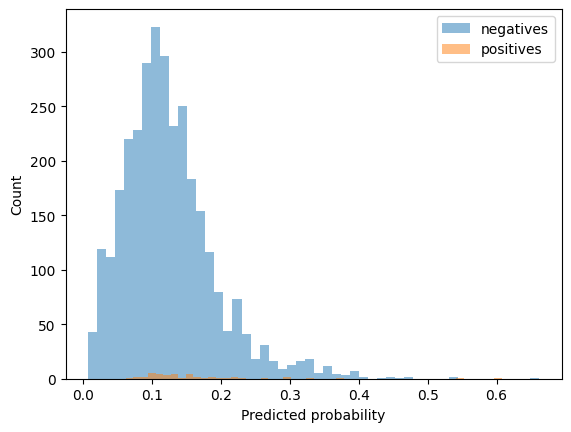

In [7]:
import matplotlib.pyplot as plt
plt.hist(val_proba[y_val==0], bins=50, alpha=0.5, label="negatives")
plt.hist(val_proba[y_val==1], bins=50, alpha=0.5, label="positives")
plt.legend(); plt.xlabel("Predicted probability"); plt.ylabel("Count");


# logisitic regression

In [19]:
import json
import joblib
import numpy as np
import pandas as pd
from os.path import exists
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, classification_report
)

# Paths/config
results_path = "logreg_grid_results_selected_subset_features_peds.parquet"   # where partial results are saved
best_model_path = "logreg_best_model_selected_subset_features_peds.pkl"  
max_iter = 2000
tol = 1e-4
random_state = 42

# --- Reload results from the previous run ---
results_df = pd.read_parquet(results_path)
print(f"Loaded {len(results_df)} parameter sets from previous grid search.")

# --- Identify best params by CV PR-AUC ---
best_row = results_df.sort_values("pr_auc_mean", ascending=False).iloc[0]
best_params = json.loads(best_row["params_json"])
print("\nBest by CV PR-AUC:", best_params, f"PR-AUC={best_row['pr_auc_mean']:.4f}")

# --- Load existing model or refit on training data ---
if exists(best_model_path):
    best_lr = joblib.load(best_model_path)
    print(f"Loaded existing best model from: {best_model_path}")
else:
    # Merge params with your overrides
    model_kwargs = dict(best_params)
    model_kwargs.update(dict(max_iter=max_iter, tol=tol, random_state=random_state))
    best_lr = LogisticRegression(**model_kwargs)
    best_lr.fit(X_train, y_train)
    joblib.dump(best_lr, best_model_path)
    print(f"Trained and saved best model to: {best_model_path}")

# --- Evaluate on validation and test sets ---
val_proba  = best_lr.predict_proba(X_val)[:, 1]
test_proba = best_lr.predict_proba(X_test)[:, 1]

print(f"[VAL]  ROC AUC={roc_auc_score(y_val, val_proba):.4f} | PR AUC={average_precision_score(y_val, val_proba):.4f}")
print(f"[TEST] ROC AUC={roc_auc_score(y_test, test_proba):.4f} | PR AUC={average_precision_score(y_test, test_proba):.4f}")

# # --- Determine threshold by max F1 on validation set ---
# prec, rec, thr = precision_recall_curve(y_val, val_proba)
# f1s = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-12)
# t_star = float(thr[np.nanargmax(f1s)])

# val_pred  = (val_proba  >= t_star).astype(int)
# test_pred = (test_proba >= t_star).astype(int)

# print(f"\nChosen threshold (VAL, max F1): {t_star:.6f}")
# print("[VAL]  report:\n",  classification_report(y_val,  val_pred,  digits=3))
# print("[TEST] report:\n", classification_report(y_test, test_pred, digits=3))

# t95 = threshold_for_sensitivity(y_val, val_proba, target_sens=0.95)
# print(f"VAL threshold for sens>=0.95: {t95:.6f}")

# val_pred  = (val_proba  >= t95).astype(int)
# test_pred = (test_proba >= t95).astype(int)

# print("[VAL @95% sens]\n",  classification_report(y_val,  val_pred,  digits=3))
# print("[TEST @95% sens]\n", classification_report(y_test, test_pred, digits=3))

t_sens95 = threshold_for_sensitivity(y_val, val_proba, target_sens=0.95)
print(f"\nVAL threshold for sens>=0.95: {t_sens95:.6f}")

# You can add any fixed thresholds you want to compare
candidate_thresholds = [
    t_sens95 - 0.05,
    t_sens95 - 0.01,
    t_sens95,
    t_sens95 + 0.01,
    t_sens95 + 0.03,
    t_sens95 + 0.5
]

# 6) build tables for VAL and TEST
val_rows = [metrics_at_threshold(y_val, val_proba, thr) for thr in candidate_thresholds]
test_rows = [metrics_at_threshold(y_test, test_proba, thr) for thr in candidate_thresholds]

val_df = pd.DataFrame(val_rows).sort_values("threshold").reset_index(drop=True)
test_df = pd.DataFrame(test_rows).sort_values("threshold").reset_index(drop=True)

# 7) print nicely (you can to_parquet/csv later)
pd.set_option("display.precision", 4)
print("\nVAL metrics by threshold:")
print(val_df)

print("\nTEST metrics by threshold:")
print(test_df)

# 8) still show the classic sklearn report at the sens>=95% threshold
val_pred  = (val_proba  >= t_sens95).astype(int)
test_pred = (test_proba >= t_sens95).astype(int)

print("\n[VAL @95% sens]\n",  classification_report(y_val,  val_pred,  digits=3))
print("\n[TEST @95% sens]\n", classification_report(y_test, test_pred, digits=3))

Loaded 300 parameter sets from previous grid search.

Best by CV PR-AUC: {'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'} PR-AUC=0.0779
Loaded existing best model from: logreg_best_model_selected_subset_features_peds.pkl
[VAL]  ROC AUC=0.6513 | PR AUC=0.0301
[TEST] ROC AUC=0.7207 | PR AUC=0.0462

VAL threshold for sens>=0.95: 0.015197

VAL metrics by threshold:
   threshold     PPV     NPV  Sensitivity  Specificity  Prevalence  Accuracy  \
0    -0.0348  0.0135  0.0000       1.0000       0.0000      0.0135    0.0135   
1     0.0052  0.0136  1.0000       1.0000       0.0080      0.0135    0.0214   
2     0.0152  0.0160  0.9968       0.9535       0.1994      0.0135    0.2096   
3     0.0252  0.0183  0.9920       0.7209       0.4713      0.0135    0.4747   
4     0.0452  0.0293  0.9900       0.3953       0.8207      0.0135    0.8150   
5     0.5152  0.0000  0.9865       0.0000       1.0000      0.0135    0.9865   

       F1  TP    FP    TN  FN  defer_rate   miss_rate  


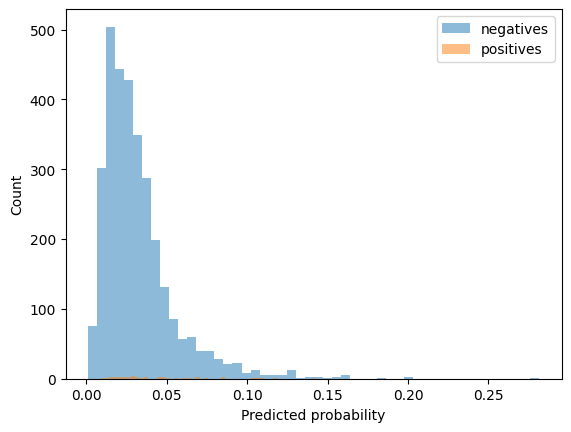

In [20]:
import matplotlib.pyplot as plt
plt.hist(val_proba[y_val==0], bins=50, alpha=0.5, label="negatives")
plt.hist(val_proba[y_val==1], bins=50, alpha=0.5, label="positives")
plt.legend(); plt.xlabel("Predicted probability"); plt.ylabel("Count");


# point system

In [21]:
# Get the coefficients
coefficients = best_lr.coef_[0]  # Coefficients for the features
intercept = best_lr.intercept_[0]  # Intercept term

# Print the coefficients and intercept
print("Coefficients:", coefficients)
print("Intercept:", intercept)

Coefficients: [ 0.02941506 -1.06636255  0.17597462  0.11834948  0.10042259  0.25746873
  0.17742167 -0.27767333  0.06659377 -0.06102379  0.24204945  0.11549716
 -0.09195307  0.02980211 -0.10711579 -0.33605076  0.03875438  0.05711388
 -0.65332422 -0.28919956 -0.52618573 -0.41633805 -0.44294994 -0.49957383
 -0.59896176 -0.34356201 -0.46814272 -0.47438105  0.92319512]
Intercept: -0.9722209075915466


In [36]:
import numpy as np
import pandas as pd

feature_names = X_train.columns
non_zero_indices = np.where(coefficients != 0)[0]
non_zero_features = feature_names[non_zero_indices]
non_zero_coefficients = coefficients[non_zero_indices]

# Combine into a DataFrame for sorting
coef_df = pd.DataFrame({
    "Feature": non_zero_features,
    "Coefficient": non_zero_coefficients,
    "AbsValue": np.abs(non_zero_coefficients)
})

# Sort by absolute coefficient value (descending)
coef_df = coef_df.sort_values(by="AbsValue", ascending=False)

# Print sorted results
for _, row in coef_df.iterrows():
    print(f"Feature: {row['Feature']}, Coefficient: {row['Coefficient']}")


Feature: cat__Leukocyte_Esterase_NEGATIVE, Coefficient: -0.7910715215293912
Feature: num__max_neutrophils, Coefficient: 0.5976574302095463
Feature: cat__Bacteria_urine_NEGATIVE, Coefficient: -0.5002011691153248
Feature: cat__Nitrite_urine_NEGATIVE, Coefficient: -0.31563811344533493
Feature: num__temp_max_c, Coefficient: 0.29858460124105296
Feature: num__min_plt, Coefficient: -0.249859314309165
Feature: cat__gender_Female, Coefficient: -0.209050204720691
Feature: num__min_hgb, Coefficient: -0.1605484823026367
Feature: bin__has_any_line, Coefficient: 0.15141520924764765
Feature: num__max_lactate, Coefficient: 0.1371185711118146
Feature: num__sysbp_min, Coefficient: -0.11243310584391966
Feature: num__age, Coefficient: 0.10133759469218521
Feature: num__hr_max, Coefficient: 0.08510079246103561
Feature: num__max_glucose, Coefficient: 0.07657549745874785
Feature: num__min_lymphocytes, Coefficient: -0.06364533107836139
Feature: num__spo2_min, Coefficient: 0.0612996219669972
Feature: cat__WBC_u

In [ ]:
# # Calculate medians for all features in your training data
# medians = X_train.median().to_dict()

# # Or if you want to be more specific and only include the features that have non-zero coefficients:
# # First get the non-zero features
# non_zero_indices = np.where(coefficients != 0)[0]
# non_zero_features = np.array(feature_names)[non_zero_indices]

# # Then calculate medians only for those features
# medians = {feature: X_train[feature].median() for feature in non_zero_features}

In [22]:
import numpy as np
import pandas as pd

def build_points_table_from_standardized(
    ct,
    X_train_base: pd.DataFrame,   # raw (pre-ColumnTransformer) TRAIN features
    feature_names: np.ndarray,    # X_train.columns (after transform)
    coefficients: np.ndarray,     # fitted coef_ aligned to X_train.columns
    scaling_factor: float = 10.0,
    rescale_coefficients_to_original_units: bool = False,
):
    """
    Create a points table with conditions in ORIGINAL units.
    Handles:
      - num: StandardScaler
      - cat: OneHotEncoder
      - bin: passthrough
    """

    # ---- 1) Pre-compute per-feature raw medians (train-only, original units)
    raw_medians = X_train_base.median(numeric_only=True).to_dict()

    # ---- 2) If wanted, convert standardized coefs -> original-unit coefs
    # For numeric columns, w_orig = w_std / std; others unchanged.
    # We need a lookup from transformed num feature -> std used by StandardScaler.
    std_lookup = {}
    # Find the StandardScaler inside the ColumnTransformer
    for name, trans, cols in ct.transformers_:
        if name == "num" and hasattr(trans, "scale_"):
            # ColumnTransformer with verbose_feature_names_out prefixes "num__"
            # and keeps column order aligned with 'cols'
            for col, std in zip(cols, trans.scale_):
                std_lookup[f"num__{col}"] = float(std)

    # Optionally rescale coefficients for numeric features
    effective_coef = []
    for fname, coef in zip(feature_names, coefficients):
        if rescale_coefficients_to_original_units and fname in std_lookup:
            std = std_lookup[fname]
            # Guard against std==0 after scaling
            coef = coef / std if std not in (0.0, None) else 0.0
        effective_coef.append(coef)
    effective_coef = np.array(effective_coef)

    # ---- 3) Build readable conditions + points
    rows = []
    for fname, coef in zip(feature_names, effective_coef):
        if coef == 0:
            continue  # skip zeros

        # NUMERIC (standardized)
        if fname.startswith("num__"):
            orig = fname.split("__", 1)[1]  # e.g., "temp_avg_c"
            med = raw_medians.get(orig, None)

            # If we don't have a median (e.g., non-numeric), skip gracefully
            if med is None or pd.isna(med):
                cond = "value present"
            else:
                # Make sign/summary-friendly thresholds
                text_thresh = f"{med:.3f}"
                # Special case: if you want different direction for min/max
                if "min" in orig:
                    cond = (f"> {text_thresh}" if coef > 0 else f"< {text_thresh}")
                    pts  = round(abs(coef) * scaling_factor)
                elif "max" in orig:
                    cond = (f"> {text_thresh}" if coef > 0 else f"< {text_thresh}")
                    pts  = round(abs(coef) * scaling_factor)
                else:
                    # avg/median/mode/other numeric
                    cond = (f"> {text_thresh}" if coef > 0 else f"< {text_thresh}")
                    pts  = round(abs(coef) * scaling_factor)

            rows.append({
                "Feature": orig,
                "Condition": cond,
                "Points": pts
            })

        # CATEGORICAL (one-hot)
        elif fname.startswith("cat__"):
            # e.g., "cat__race_White" -> col="race", level="White"
            tail = fname.split("__", 1)[1]
            if "_" in tail:
                col, level = tail.split("_", 1)
            else:
                col, level = tail, "1"

            cond = f"== {level}"
            pts  = round(coef * scaling_factor)
            rows.append({
                "Feature": f"{col}",
                "Condition": cond,
                "Points": pts
            })

        # BINARY passthrough
        elif fname.startswith("bin__"):
            orig = fname.split("__", 1)[1]
            cond = "== 1" if coef > 0 else "== 0"
            pts  = round(abs(coef) * scaling_factor)
            rows.append({
                "Feature": orig,
                "Condition": cond,
                "Points": pts
            })

        else:
            # Fallback (shouldn’t happen with the current ct)
            rows.append({
                "Feature": fname,
                "Condition": "—",
                "Points": round(coef * scaling_factor)
            })

    df = pd.DataFrame(rows)

    # ---- 4) Sort by absolute point weight (largest first)
    df["abs_points"] = df["Points"].abs()
    df = df.sort_values("abs_points", ascending=False).drop(columns=["abs_points"]).reset_index(drop=True)
    return df


In [24]:
# feature_names and coefficients should align with X_train (post-transform)
feature_names = X_train.columns.to_numpy()
coefficients = best_lr.coef_.ravel()  # or your model's coef_

df_points_table = build_points_table_from_standardized(
    ct=ct,
    X_train_base=X_train_base,                      # raw (pre-transform) training frame
    feature_names=feature_names,
    coefficients=coefficients,
    scaling_factor=10,
    rescale_coefficients_to_original_units=False    # set True if you want per *original-unit* effects
)


In [31]:
# assuming you already have `df_points_table`
df_pos = (df_points_table[df_points_table["Points"] > 0]
          .sort_values("Points", ascending=False)
          .reset_index(drop=True))

# (optional) top-k
top_k = 30
df_points_table_topk = df_pos.head(top_k)
print(df_points_table_topk)


            Feature Condition  Points
0               bmi  < 18.520      11
1      has_any_line      == 1       9
2         diabp_min  < 63.000       3
3           min_plt     < 150       3
4            hr_max     > 100       3
5         sysbp_min      < 90       2
6         adi_score   > 4.752       2
7   max_neutrophils      > 70       2
8          resp_max  > 26.000       1
9        temp_max_c      > 38       1
10      max_lactate     > 1.5       1
11  min_lymphocytes      < 20       1
12          max_wbc   < 9.200       1
13          max_anc   > 5.380       1
14          min_hgb      < 12       1


In [26]:
# Keep has_any_line, drop spo2_min, apply custom thresholds to others
manual_cond = {
    "max_neutrophils": "> 70",     # 0
    "temp_max_c": "> 38",          # 1
    "min_hgb": "< 12",             # 2
    "min_plt": "< 150",            # 3
    "has_any_line": "== 1",        # 4 (explicitly keep this one)
    # skip spo2_min
    "bmi": "< 18.520",              # 6
    "hr_max": "> 100",             # 7
    "sysbp_min": "< 90",           # 8
    "max_lactate": "> 1.5",        # 9
    "min_lymphocytes": "< 20",     # 10
    "max_glucose": "> 127",        # 11
}

# Apply manual thresholds
for feat, cond in manual_cond.items():
    df_points_table.loc[df_points_table["Feature"] == feat, "Condition"] = cond

# Remove spo2_min completely
df_points_table = df_points_table[df_points_table["Feature"] != "spo2_min"]

# Optional: only keep positive-point rules and sort
df_pos = (
    df_points_table[df_points_table["Points"] > 0]
    .sort_values("Points", ascending=False)
    .reset_index(drop=True)
)

print(df_pos)


            Feature Condition  Points
0               bmi  < 18.520      11
1      has_any_line      == 1       9
2         diabp_min  < 63.000       3
3           min_plt     < 150       3
4            hr_max     > 100       3
5         sysbp_min      < 90       2
6         adi_score   > 4.752       2
7   max_neutrophils      > 70       2
8          resp_max  > 26.000       1
9        temp_max_c      > 38       1
10      max_lactate     > 1.5       1
11  min_lymphocytes      < 20       1
12          max_wbc   < 9.200       1
13          max_anc   > 5.380       1
14          min_hgb      < 12       1


In [27]:
import numpy as np

def make_rules_from_points_table(df_points_table):
    rules = []
    for _, row in df_points_table.iterrows():
        feature = row["Feature"]
        condition_str = str(row["Condition"]).strip()
        points = int(row["Points"])
        
        # Skip non-positive points (optional)
        if points <= 0:
            continue
        
        # Parse condition string like "> 36.8", "< 125.0", "== 1"
        if condition_str.startswith(">"):
            threshold = float(condition_str.replace(">", "").strip())
            rule = (feature, lambda x, thr=threshold: x > thr, points)
        elif condition_str.startswith("<"):
            threshold = float(condition_str.replace("<", "").strip())
            rule = (feature, lambda x, thr=threshold: x < thr, points)
        elif condition_str.startswith("=="):
            value = condition_str.replace("==", "").strip()
            # Try to cast to numeric; otherwise keep string
            try:
                val = float(value)
            except ValueError:
                val = value
            rule = (feature, lambda x, val=val: x == val, points)
        else:
            raise ValueError(f"Unsupported condition format: {condition_str}")

        rules.append(rule)
    return rules


In [28]:
def evaluate_thresholds(X, y_true, rules, thresholds):
    results = []
    X = X.copy()
    X["total_points"] = 0
    for feature, condition, pts in rules:
        if feature in X.columns:
            X["total_points"] += np.where(condition(X[feature]), pts, 0)

    for t in thresholds:
        y_pred = (X["total_points"] >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
        sens = tp / (tp + fn + 1e-12)
        spec = tn / (tn + fp + 1e-12)
        ppv  = tp / (tp + fp + 1e-12)
        npv  = tn / (tn + fn + 1e-12)
        results.append((t, sens, spec, ppv, npv))
    return pd.DataFrame(results, columns=["threshold","sensitivity","specificity","PPV","NPV"])


In [ ]:
rules = make_rules_from_points_table(df_points_table_topk)
# rules =  make_rules_from_points_table(df_pos)


In [33]:
thresholds = range(0, 20)  # or np.arange(0, 20, 0.5)
df_thresh = evaluate_thresholds(X_val_base, y_val, rules, thresholds)
print(df_thresh)


    threshold  sensitivity  specificity     PPV     NPV
0           0       1.0000       0.0000  0.0135  0.0000
1           1       1.0000       0.0006  0.0135  1.0000
2           2       1.0000       0.0057  0.0136  1.0000
3           3       1.0000       0.0092  0.0136  1.0000
4           4       1.0000       0.0143  0.0137  1.0000
5           5       1.0000       0.0338  0.0140  1.0000
6           6       0.9767       0.0516  0.0139  0.9939
7           7       0.9767       0.0809  0.0143  0.9961
8           8       0.9070       0.1226  0.0140  0.9897
9           9       0.8837       0.1688  0.0144  0.9907
10         10       0.8837       0.2127  0.0151  0.9926
11         11       0.8372       0.2573  0.0152  0.9914
12         12       0.7209       0.2930  0.0138  0.9871
13         13       0.6977       0.3239  0.0139  0.9874
14         14       0.6279       0.3459  0.0130  0.9855
15         15       0.6279       0.3678  0.0134  0.9863
16         16       0.5814       0.3975  0.0130 

In [45]:
thresholds = range(0, 15)  # or np.arange(0, 20, 0.5)
df_thresh = evaluate_thresholds(X_val_base, y_val, rules, thresholds)
print(df_thresh)


    threshold  sensitivity  specificity     PPV     NPV
0           0       1.0000       0.0000  0.0135  0.0000
1           1       1.0000       0.0006  0.0135  1.0000
2           2       1.0000       0.0057  0.0136  1.0000
3           3       1.0000       0.0092  0.0136  1.0000
4           4       1.0000       0.0143  0.0137  1.0000
5           5       1.0000       0.0338  0.0140  1.0000
6           6       0.9767       0.0516  0.0139  0.9939
7           7       0.9767       0.0809  0.0143  0.9961
8           8       0.9070       0.1226  0.0140  0.9897
9           9       0.8837       0.1688  0.0144  0.9907
10         10       0.8837       0.2127  0.0151  0.9926
11         11       0.8372       0.2573  0.0152  0.9914
12         12       0.7209       0.2930  0.0138  0.9871
13         13       0.6977       0.3239  0.0139  0.9874
14         14       0.6279       0.3459  0.0130  0.9855


In [44]:
best_threshold = 7  # example from validation
print(f"the threshold is {best_threshold}")
X_test_base_copy = X_test_base.copy()
X_test_base_copy["total_points"] = 0
for f, cond, pts in rules:
    if f in X_test_base_copy.columns:
        X_test_base_copy["total_points"] += np.where(cond(X_test_base_copy[f]), pts, 0)

y_pred_test = (X_test_base_copy["total_points"] >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_test, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
print("Test Sensitivity:", tp/(tp+fn))
print("Test Specificity:", tn/(tn+fp))
print("Test PPV:", tp/(tp+fp))
print("Test NPV:", tn/(tn+fn))

# Total number of test samples
total = tn + fp + fn + tp

# Defer rate = (TN + FN) / Total = proportion predicted negative
defer_rate = (tn + fn) / total

# Miss rate = FN / (TP + FN) = 1 - Sensitivity
miss_rate = fn / (tp + fn)

print(f"Defer rate: {defer_rate:.3f}")
print(f"Miss rate: {miss_rate:.3f}")



the threshold is 7
Test Sensitivity: 0.9571428571428572
Test Specificity: 0.06676669167291822
Test PPV: 0.017636220057909976
Test NPV: 0.9888888888888889
Defer rate: 0.066
Miss rate: 0.043


# SHAP for hgb

In [46]:
import shap
import pandas as pd

explainer = shap.TreeExplainer(hgb)
shap_values = explainer.shap_values(X_train)

# mean absolute shap importance
mean_abs_shap = np.abs(shap_values).mean(axis=0)
df_shap = pd.DataFrame({
    "Feature": X_train.columns,
    "MeanAbsSHAP": mean_abs_shap
}).sort_values("MeanAbsSHAP", ascending=False)

# scale to points
df_shap["Points"] = (10 * df_shap["MeanAbsSHAP"] / df_shap["MeanAbsSHAP"].max()).round(1)
print(df_shap.head(15))


                 Feature  MeanAbsSHAP  Points
10  num__max_neutrophils       0.2226    10.0
15          num__min_plt       0.1654     7.4
2         num__adi_score       0.1405     6.3
0          num__age_days       0.1403     6.3
3        num__temp_max_c       0.1358     6.1
12  num__min_lymphocytes       0.1042     4.7
5            num__hr_max       0.1006     4.5
11          num__max_anc       0.0776     3.5
7         num__diabp_min       0.0587     2.6
14          num__min_hgb       0.0531     2.4
9           num__max_wbc       0.0518     2.3
1               num__bmi       0.0428     1.9
16      num__max_glucose       0.0392     1.8
6         num__sysbp_min       0.0262     1.2
13          num__min_alc       0.0250     1.1


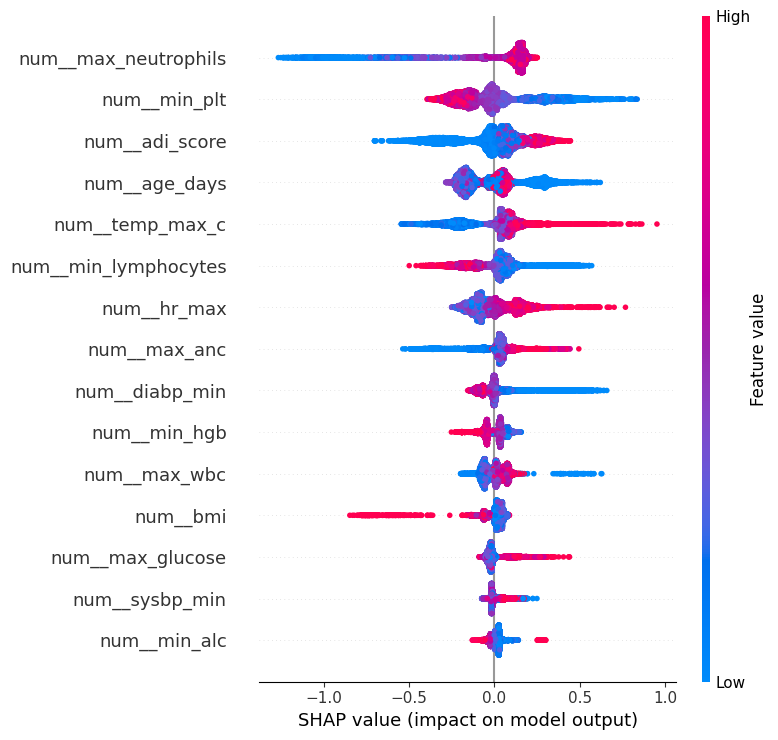

In [47]:
shap.summary_plot(shap_values, X_train, max_display=15)


In [48]:
import pandas as pd
import numpy as np

# shap_values: (n_samples, n_features)
# X_train: pandas DataFrame with columns matching shap_values
sv = shap_values
cols = X_train.columns

# 1) mean absolute SHAP = importance
mean_abs = np.abs(sv).mean(axis=0)

# 2) mean SHAP (with sign) = average direction
mean_signed = sv.mean(axis=0)

df_shap = pd.DataFrame({
    "Feature_raw": cols,
    "mean_abs_shap": mean_abs,
    "mean_shap": mean_signed,
})

# 3) make it prettier: strip num__/cat__/bin__
def nice_name(col):
    if col.startswith("num__"):
        return col.replace("num__", "")
    if col.startswith("cat__"):
        return col.replace("cat__", "")
    if col.startswith("bin__"):
        return col.replace("bin__", "")
    return col

df_shap["Feature"] = df_shap["Feature_raw"].apply(nice_name)

# 4) basic direction label
def direction(row):
    if row["mean_shap"] > 0:
        return "higher → higher risk"
    elif row["mean_shap"] < 0:
        return "higher → lower risk"
    else:
        return "neutral"

df_shap["Direction"] = df_shap.apply(direction, axis=1)

# 5) sort by importance
df_shap = df_shap.sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

# 6) keep top N
topN = 15
df_top = df_shap.head(topN)[["Feature", "mean_abs_shap", "mean_shap", "Direction"]]
print(df_top.to_string(index=False))


        Feature  mean_abs_shap  mean_shap            Direction
max_neutrophils         0.2226    -0.0056  higher → lower risk
        min_plt         0.1654    -0.0024  higher → lower risk
      adi_score         0.1405    -0.0027  higher → lower risk
       age_days         0.1403    -0.0065  higher → lower risk
     temp_max_c         0.1358    -0.0023  higher → lower risk
min_lymphocytes         0.1042     0.0105 higher → higher risk
         hr_max         0.1006    -0.0041  higher → lower risk
        max_anc         0.0776     0.0051 higher → higher risk
      diabp_min         0.0587    -0.0033  higher → lower risk
        min_hgb         0.0531     0.0027 higher → higher risk
        max_wbc         0.0518    -0.0012  higher → lower risk
            bmi         0.0428     0.0008 higher → higher risk
    max_glucose         0.0392    -0.0028  higher → lower risk
      sysbp_min         0.0262     0.0051 higher → higher risk
        min_alc         0.0250     0.0051 higher → high